## This notebook is to explore the data issue, 
## where 1/3 of the records have zero IP count but with positive spam volume

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# read the Excel into dataframe
df = pd.read_excel('./for_randomization_170426.xlsx')
df.to_csv('./for_randomization_170426.csv')

In [3]:
df.describe()

,DossierID,hsic,hasFacebook,hasTwitter,hasWeibo,hasWeChat,hasTencentWeibo,ip201512,ip201601,ip201602,...,pv201606,pv201607,pv201608,pv201609,pv201610,pv201611,pv201612,pv201701,pv201702,pv201703
count,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.0,1.262000e+03,1.262000e+03,...,1262.000000,1262.0,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000
mean,1910.603803,626104.491284,0.480190,0.342314,0.267829,0.240095,0.126783,0.0,8.404276e+06,7.622150e+06,...,166.179873,0.0,141.824089,329.815372,50.133122,244.924723,233.512678,62.649762,195.183043,117.457211
std,587.160233,119032.960562,0.499805,0.474672,0.443003,0.427310,0.332862,0.0,9.112511e+07,8.478178e+07,...,2520.914476,0.0,1453.034623,3197.647595,485.242398,2205.902906,2370.397172,887.293733,2882.801924,1705.388801
min,1001.000000,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1401.500000,611000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1825.500000,620200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.174400e+04,2.867200e+04,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2531.500000,639100.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,1.904640e+05,1.720320e+05,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2922.000000,960299.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,2.147484e+09,2.147484e+09,...,71179.000000,0.0,34405.000000,79039.000000,10741.000000,36502.000000,57849.000000,21765.000000,69434.000000,43868.000000


In [4]:
# collecting all YYYMMs from the column names
yyyymms = []
for col in df.columns:
    if col.startswith('ip'):
        yyyymms.append(col[2:])
print yyyymms

[u'201512', u'201601', u'201602', u'201603', u'201604', u'201605', u'201606', u'201607', u'201608', u'201609', u'201610', u'201611', u'201612', u'201701', u'201702', u'201703']


### Now let's see how many "weird" records are there
+ "weird records" have zero IP with positive spam volume
+ We see that 35% of the records are weird...
+ I also checked which months have the most weird records. 
+ And it turns out that 2016/07 has the most weird situations.

In [5]:
from collections import Counter

weird_yyyymm_list = []
total_count = len(df)
weird_ids = set()

for idx, row in df.iterrows():
    for yyyymm in yyyymms:
        ip_count = row['ip{}'.format(yyyymm)]
        cv_count = row['cv{}'.format(yyyymm)]
        pv_count = row['pv{}'.format(yyyymm)]
        if ip_count == 0 and (cv_count + pv_count > 0):
            weird_ids.add(idx)
            weird_yyyymm_list.append(yyyymm)

weird_count = len(weird_ids)
print weird_count
print 100.0 * weird_count / total_count

c = Counter(weird_yyyymm_list)
print c.most_common(10)

448
35.499207607
[(u'201607', 446), (u'201608', 3), (u'201612', 2), (u'201611', 2), (u'201609', 2), (u'201603', 1)]


In [6]:
# new dataframe with numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = df.select_dtypes(include=numerics)

for col in new_df.columns:
    if new_df[col].max() <= 0.0:
        print col, new_df[col].max()

ip201512 0
ip201607 0
nb201512 0
nb201607 0
cv201512 0
pv201512 0
pv201601 0
pv201607 0


+ This shows that actually ip201512 and ip201607 are always zero.
+ Accordingly, nb201512 and nb201607 are also always zero. Actually, ip and nb data are from the same raw sources.
+ Since pv data is based on ip/nb data, it is natural to see pv201512 and pv201607 are zero as well
+ The only exception is pv201601

## Let's see if there is any temporal pattern on IP/netblock count

+ We see a big dip in three months: 2016/06,2016/07,2016/08

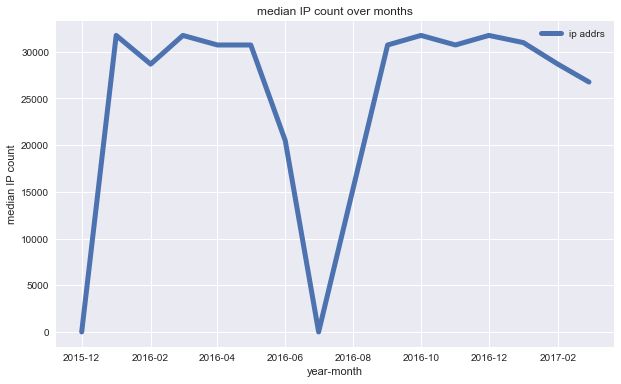

In [7]:
from datetime import datetime

month_list = []
ip_list = []
nb_list = []
as_list = []
for col in new_df.columns:
    if col.startswith('ip'):
        ip_list.append(new_df[col].median())
        yyyymm = col[2:]
        yyyy = int(yyyymm[:4])
        mm = int(yyyymm[4:])
        month_ = datetime(yyyy, mm, 1)
        month_list.append(month_)
    if col.startswith('nb'):
        nb_list.append(new_df[col].median())
    if col.startswith('as'):
        as_list.append(new_df[col].median())
        

plt.figure(figsize=(10, 6), dpi=80)
#plt.xticks()
plt.title('median IP count over months')
plt.xlabel('year-month')
plt.ylabel('median IP count')
plt.plot(month_list, ip_list, label='ip addrs', linewidth=5)
plt.legend(loc='best');
#plt.plot(month_list, nb_list, label='netblocks');

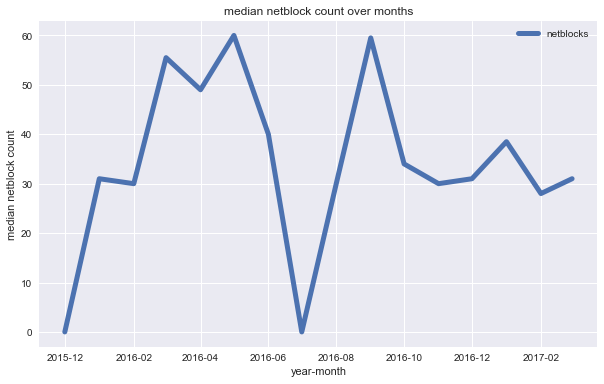

In [8]:
plt.figure(figsize=(10, 6))
#plt.xticks()
plt.title('median netblock count over months')
plt.xlabel('year-month')
plt.ylabel('median netblock count')
#plt.plot(month_list, ip_list, label='ip addrs', linewidth=5);
plt.plot(month_list, nb_list, label='netblocks', linewidth=5)
plt.legend(loc='best');

### I started to look into the raw data at emerald machine

+ IP->NB->AS mappings are one of our key datasets. 
+ Our emerald system uses two data sources - bulk_cymru and CBL volume data - to generate daily NB->AS mappings
+ I found that the 2015/12 raw data is there. It seems that the intermediate files were deleted due to hard drive space issue. 
+ **But, unfortunately, it seems that there were raw data collection issues from 2016/06/21 to 2016/08/15. You will recognize that the file sizes of these dates are zero.**
+ Given that our system **did** download zero-sized files, this means that our data source had the issue there. I.e., unlikely our system's fault

In [9]:
"""
gene@emerald:/data/bulk_cymru/raw$ ls -lh rbl_ipv4_zone_1512*
-rw-r--r-- 1 cronuser users 123M Dec  1  2015 rbl_ipv4_zone_151201.txt
-rw-r--r-- 1 cronuser users 123M Dec  2  2015 rbl_ipv4_zone_151202.txt
-rw-r--r-- 1 cronuser users 123M Dec  3  2015 rbl_ipv4_zone_151203.txt
-rw-r--r-- 1 cronuser users 124M Dec  4  2015 rbl_ipv4_zone_151204.txt
-rw-r--r-- 1 cronuser users 123M Dec  5  2015 rbl_ipv4_zone_151205.txt
-rw-r--r-- 1 cronuser users 124M Dec  6  2015 rbl_ipv4_zone_151206.txt
-rw-r--r-- 1 cronuser users 124M Dec  7  2015 rbl_ipv4_zone_151207.txt
-rw-r--r-- 1 cronuser users 124M Dec  8  2015 rbl_ipv4_zone_151208.txt
-rw-r--r-- 1 cronuser users 124M Dec  9  2015 rbl_ipv4_zone_151209.txt
-rw-r--r-- 1 cronuser users 124M Dec 10  2015 rbl_ipv4_zone_151210.txt
-rw-r--r-- 1 cronuser users 124M Dec 11  2015 rbl_ipv4_zone_151211.txt
-rw-r--r-- 1 cronuser users 124M Dec 12  2015 rbl_ipv4_zone_151212.txt
-rw-r--r-- 1 cronuser users 124M Dec 13  2015 rbl_ipv4_zone_151213.txt
-rw-r--r-- 1 cronuser users 124M Dec 14  2015 rbl_ipv4_zone_151214.txt
-rw-r--r-- 1 cronuser users 124M Dec 15  2015 rbl_ipv4_zone_151215.txt
-rw-r--r-- 1 cronuser users 124M Dec 16  2015 rbl_ipv4_zone_151216.txt
-rw-r--r-- 1 cronuser users 124M Dec 17  2015 rbl_ipv4_zone_151217.txt
-rw-r--r-- 1 cronuser users 124M Dec 18  2015 rbl_ipv4_zone_151218.txt
-rw-r--r-- 1 cronuser users 124M Dec 19  2015 rbl_ipv4_zone_151219.txt
-rw-r--r-- 1 cronuser users 124M Dec 20  2015 rbl_ipv4_zone_151220.txt
-rw-r--r-- 1 cronuser users 124M Dec 21  2015 rbl_ipv4_zone_151221.txt
-rw-r--r-- 1 cronuser users 124M Dec 22  2015 rbl_ipv4_zone_151222.txt
-rw-r--r-- 1 cronuser users 124M Dec 23  2015 rbl_ipv4_zone_151223.txt
-rw-r--r-- 1 cronuser users 124M Dec 24  2015 rbl_ipv4_zone_151224.txt
-rw-r--r-- 1 cronuser users 124M Dec 25  2015 rbl_ipv4_zone_151225.txt
-rw-r--r-- 1 cronuser users 124M Dec 26  2015 rbl_ipv4_zone_151226.txt
-rw-r--r-- 1 cronuser users 124M Dec 27  2015 rbl_ipv4_zone_151227.txt
-rw-r--r-- 1 cronuser users 124M Dec 28  2015 rbl_ipv4_zone_151228.txt
-rw-r--r-- 1 cronuser users 124M Dec 29  2015 rbl_ipv4_zone_151229.txt
-rw-r--r-- 1 cronuser users 124M Dec 30  2015 rbl_ipv4_zone_151230.txt
-rw-r--r-- 1 cronuser users 124M Dec 31  2015 rbl_ipv4_zone_151231.txt




gene@emerald:/data/bulk_cymru/raw$ ls -lh rbl_ipv4_zone_1606*
-rw-r--r-- 1 cronuser users 128M Jun  1  2016 rbl_ipv4_zone_160601.txt
-rw-r--r-- 1 cronuser users 129M Jun  2  2016 rbl_ipv4_zone_160602.txt
-rw-r--r-- 1 cronuser users 128M Jun  3  2016 rbl_ipv4_zone_160603.txt
-rw-r--r-- 1 cronuser users 129M Jun  4  2016 rbl_ipv4_zone_160604.txt
-rw-r--r-- 1 cronuser users 129M Jun  5  2016 rbl_ipv4_zone_160605.txt
-rw-r--r-- 1 cronuser users 129M Jun  6  2016 rbl_ipv4_zone_160606.txt
-rw-r--r-- 1 cronuser users 129M Jun  7  2016 rbl_ipv4_zone_160607.txt
-rw-r--r-- 1 cronuser users 129M Jun  8  2016 rbl_ipv4_zone_160608.txt
-rw-r--r-- 1 cronuser users 129M Jun  9  2016 rbl_ipv4_zone_160609.txt
-rw-r--r-- 1 cronuser users 129M Jun 10  2016 rbl_ipv4_zone_160610.txt
-rw-r--r-- 1 cronuser users 129M Jun 11  2016 rbl_ipv4_zone_160611.txt
-rw-r--r-- 1 cronuser users 129M Jun 12  2016 rbl_ipv4_zone_160612.txt
-rw-r--r-- 1 cronuser users 129M Jun 13  2016 rbl_ipv4_zone_160613.txt
-rw-r--r-- 1 cronuser users 130M Jun 14  2016 rbl_ipv4_zone_160614.txt
-rw-r--r-- 1 cronuser users 129M Jun 15  2016 rbl_ipv4_zone_160615.txt
-rw-r--r-- 1 cronuser users 129M Jun 16  2016 rbl_ipv4_zone_160616.txt
-rw-r--r-- 1 cronuser users 129M Jun 17  2016 rbl_ipv4_zone_160617.txt
-rw-r--r-- 1 cronuser users 129M Jun 18  2016 rbl_ipv4_zone_160618.txt
-rw-r--r-- 1 cronuser users 129M Jun 19  2016 rbl_ipv4_zone_160619.txt
-rw-r--r-- 1 cronuser users 129M Jun 20  2016 rbl_ipv4_zone_160620.txt
-rw-r--r-- 1 cronuser users    0 Jun 21  2016 rbl_ipv4_zone_160621.txt
-rw-r--r-- 1 cronuser users    0 Jun 22  2016 rbl_ipv4_zone_160622.txt
-rw-r--r-- 1 cronuser users    0 Jun 23  2016 rbl_ipv4_zone_160623.txt
-rw-r--r-- 1 cronuser users    0 Jun 24  2016 rbl_ipv4_zone_160624.txt
-rw-r--r-- 1 cronuser users    0 Jun 25  2016 rbl_ipv4_zone_160625.txt
-rw-r--r-- 1 cronuser users    0 Jun 26  2016 rbl_ipv4_zone_160626.txt
-rw-r--r-- 1 cronuser users    0 Jun 27  2016 rbl_ipv4_zone_160627.txt
-rw-r--r-- 1 cronuser users    0 Jun 28  2016 rbl_ipv4_zone_160628.txt
-rw-r--r-- 1 cronuser users    0 Jun 29  2016 rbl_ipv4_zone_160629.txt
-rw-r--r-- 1 cronuser users    0 Jun 30  2016 rbl_ipv4_zone_160630.txt
-rw-r--r-- 1 cronuser users    0 Jul  1  2016 rbl_ipv4_zone_160701.txt
-rw-r--r-- 1 cronuser users    0 Jul  2  2016 rbl_ipv4_zone_160702.txt
-rw-r--r-- 1 cronuser users    0 Jul  3  2016 rbl_ipv4_zone_160703.txt
-rw-r--r-- 1 cronuser users    0 Jul  4  2016 rbl_ipv4_zone_160704.txt
-rw-r--r-- 1 cronuser users    0 Jul  5  2016 rbl_ipv4_zone_160705.txt
-rw-r--r-- 1 cronuser users    0 Jul  6  2016 rbl_ipv4_zone_160706.txt
-rw-r--r-- 1 cronuser users    0 Jul  7  2016 rbl_ipv4_zone_160707.txt
-rw-r--r-- 1 cronuser users    0 Jul  8  2016 rbl_ipv4_zone_160708.txt
-rw-r--r-- 1 cronuser users    0 Jul  9  2016 rbl_ipv4_zone_160709.txt
-rw-r--r-- 1 cronuser users    0 Jul 10  2016 rbl_ipv4_zone_160710.txt
-rw-r--r-- 1 cronuser users    0 Jul 11  2016 rbl_ipv4_zone_160711.txt
-rw-r--r-- 1 cronuser users    0 Jul 12  2016 rbl_ipv4_zone_160712.txt
-rw-r--r-- 1 cronuser users    0 Jul 14  2016 rbl_ipv4_zone_160714.txt
-rw-r--r-- 1 cronuser users    0 Jul 15  2016 rbl_ipv4_zone_160715.txt
-rw-r--r-- 1 cronuser users    0 Jul 16  2016 rbl_ipv4_zone_160716.txt
-rw-r--r-- 1 cronuser users    0 Jul 17  2016 rbl_ipv4_zone_160717.txt
-rw-r--r-- 1 cronuser users    0 Jul 18  2016 rbl_ipv4_zone_160718.txt
-rw-r--r-- 1 cronuser users    0 Jul 19  2016 rbl_ipv4_zone_160719.txt
-rw-r--r-- 1 cronuser users    0 Jul 20  2016 rbl_ipv4_zone_160720.txt
-rw-r--r-- 1 cronuser users    0 Jul 21  2016 rbl_ipv4_zone_160721.txt
-rw-r--r-- 1 cronuser users    0 Jul 22  2016 rbl_ipv4_zone_160722.txt
-rw-r--r-- 1 cronuser users    0 Jul 23  2016 rbl_ipv4_zone_160723.txt
-rw-r--r-- 1 cronuser users    0 Jul 24  2016 rbl_ipv4_zone_160724.txt
-rw-r--r-- 1 cronuser users    0 Jul 25  2016 rbl_ipv4_zone_160725.txt
-rw-r--r-- 1 cronuser users    0 Jul 26  2016 rbl_ipv4_zone_160726.txt
-rw-r--r-- 1 cronuser users    0 Jul 27  2016 rbl_ipv4_zone_160727.txt
-rw-r--r-- 1 cronuser users    0 Jul 28  2016 rbl_ipv4_zone_160728.txt
-rw-r--r-- 1 cronuser users    0 Jul 29  2016 rbl_ipv4_zone_160729.txt
-rw-r--r-- 1 cronuser users    0 Jul 30  2016 rbl_ipv4_zone_160730.txt
-rw-r--r-- 1 cronuser users    0 Jul 31  2016 rbl_ipv4_zone_160731.txt
-rw-r--r-- 1 cronuser users    0 Aug  1  2016 rbl_ipv4_zone_160801.txt
-rw-r--r-- 1 cronuser users    0 Aug  2  2016 rbl_ipv4_zone_160802.txt
-rw-r--r-- 1 cronuser users    0 Aug  3  2016 rbl_ipv4_zone_160803.txt
-rw-r--r-- 1 cronuser users    0 Aug  5  2016 rbl_ipv4_zone_160805.txt
-rw-r--r-- 1 cronuser users    0 Aug  6  2016 rbl_ipv4_zone_160806.txt
-rw-r--r-- 1 cronuser users    0 Aug  7  2016 rbl_ipv4_zone_160807.txt
-rw-r--r-- 1 cronuser users    0 Aug  8  2016 rbl_ipv4_zone_160808.txt
-rw-r--r-- 1 cronuser users    0 Aug  9  2016 rbl_ipv4_zone_160809.txt
-rw-r--r-- 1 cronuser users    0 Aug 10  2016 rbl_ipv4_zone_160810.txt
-rw-r--r-- 1 cronuser users    0 Aug 11  2016 rbl_ipv4_zone_160811.txt
-rw-r--r-- 1 cronuser users    0 Aug 12  2016 rbl_ipv4_zone_160812.txt
-rw-r--r-- 1 cronuser users    0 Aug 13  2016 rbl_ipv4_zone_160813.txt
-rw-r--r-- 1 cronuser users    0 Aug 14  2016 rbl_ipv4_zone_160814.txt
-rw-r--r-- 1 cronuser users    0 Aug 15  2016 rbl_ipv4_zone_160815.txt
-rw-r--r-- 1 cronuser users 130M Aug 17  2016 rbl_ipv4_zone_160817.txt
-rw-r--r-- 1 cronuser users 130M Aug 18  2016 rbl_ipv4_zone_160818.txt
-rw-r--r-- 1 cronuser users 130M Aug 19  2016 rbl_ipv4_zone_160819.txt
-rw-r--r-- 1 cronuser users 130M Aug 20  2016 rbl_ipv4_zone_160820.txt
-rw-r--r-- 1 cronuser users 131M Aug 21  2016 rbl_ipv4_zone_160821.txt
-rw-r--r-- 1 cronuser users 131M Aug 22  2016 rbl_ipv4_zone_160822.txt
-rw-r--r-- 1 cronuser users 131M Aug 23  2016 rbl_ipv4_zone_160823.txt
-rw-r--r-- 1 cronuser users 131M Aug 24  2016 rbl_ipv4_zone_160824.txt
-rw-r--r-- 1 cronuser users 131M Aug 25  2016 rbl_ipv4_zone_160825.txt
-rw-r--r-- 1 cronuser users 131M Aug 26  2016 rbl_ipv4_zone_160826.txt
-rw-r--r-- 1 cronuser users 131M Aug 27  2016 rbl_ipv4_zone_160827.txt
-rw-r--r-- 1 cronuser users 131M Aug 28  2016 rbl_ipv4_zone_160828.txt
-rw-r--r-- 1 cronuser users 131M Aug 29  2016 rbl_ipv4_zone_160829.txt
-rw-r--r-- 1 cronuser users 131M Aug 30  2016 rbl_ipv4_zone_160830.txt
-rw-r--r-- 1 cronuser users 131M Aug 31  2016 rbl_ipv4_zone_160831.txt
-rw-r--r-- 1 cronuser users 131M Sep  1  2016 rbl_ipv4_zone_160901.txt
-rw-r--r-- 1 cronuser users 131M Sep  2  2016 rbl_ipv4_zone_160902.txt
-rw-r--r-- 1 cronuser users 131M Sep  3  2016 rbl_ipv4_zone_160903.txt
-rw-r--r-- 1 cronuser users 131M Sep  4  2016 rbl_ipv4_zone_160904.txt
-rw-r--r-- 1 cronuser users 131M Sep  5  2016 rbl_ipv4_zone_160905.txt
-rw-r--r-- 1 cronuser users 131M Sep  6  2016 rbl_ipv4_zone_160906.txt
-rw-r--r-- 1 cronuser users 131M Sep  7  2016 rbl_ipv4_zone_160907.txt
-rw-r--r-- 1 cronuser users 131M Sep  8  2016 rbl_ipv4_zone_160908.txt
-rw-r--r-- 1 cronuser users 131M Sep  9  2016 rbl_ipv4_zone_160909.txt
-rw-r--r-- 1 cronuser users 131M Sep 10  2016 rbl_ipv4_zone_160910.txt
-rw-r--r-- 1 cronuser users 131M Sep 11  2016 rbl_ipv4_zone_160911.txt
-rw-r--r-- 1 cronuser users 131M Sep 12  2016 rbl_ipv4_zone_160912.txt
-rw-r--r-- 1 cronuser users 131M Sep 13  2016 rbl_ipv4_zone_160913.txt
-rw-r--r-- 1 cronuser users 131M Sep 14  2016 rbl_ipv4_zone_160914.txt
-rw-r--r-- 1 cronuser users 131M Sep 15  2016 rbl_ipv4_zone_160915.txt
-rw-r--r-- 1 cronuser users 131M Sep 16  2016 rbl_ipv4_zone_160916.txt
-rw-r--r-- 1 cronuser users 131M Sep 17  2016 rbl_ipv4_zone_160917.txt
-rw-r--r-- 1 cronuser users 131M Sep 18  2016 rbl_ipv4_zone_160918.txt
-rw-r--r-- 1 cronuser users 131M Sep 19  2016 rbl_ipv4_zone_160919.txt
-rw-r--r-- 1 cronuser users 131M Sep 20  2016 rbl_ipv4_zone_160920.txt
-rw-r--r-- 1 cronuser users 131M Sep 21  2016 rbl_ipv4_zone_160921.txt
-rw-r--r-- 1 cronuser users 131M Sep 22  2016 rbl_ipv4_zone_160922.txt
-rw-r--r-- 1 cronuser users 131M Sep 23  2016 rbl_ipv4_zone_160923.txt
-rw-r--r-- 1 cronuser users 131M Sep 24  2016 rbl_ipv4_zone_160924.txt
-rw-r--r-- 1 cronuser users 131M Sep 25  2016 rbl_ipv4_zone_160925.txt
-rw-r--r-- 1 cronuser users 131M Sep 26  2016 rbl_ipv4_zone_160926.txt
-rw-r--r-- 1 cronuser users 131M Sep 27  2016 rbl_ipv4_zone_160927.txt
-rw-r--r-- 1 cronuser users 131M Sep 28  2016 rbl_ipv4_zone_160928.txt
-rw-r--r-- 1 cronuser users 131M Sep 29  2016 rbl_ipv4_zone_160929.txt
-rw-r--r-- 1 cronuser users 131M Sep 30  2016 rbl_ipv4_zone_160930.txt
-rw-r--r-- 1 cronuser users 131M Oct  1  2016 rbl_ipv4_zone_161001.txt
-rw-r--r-- 1 cronuser users 131M Oct  2  2016 rbl_ipv4_zone_161002.txt
-rw-r--r-- 1 cronuser users 132M Oct  3  2016 rbl_ipv4_zone_161003.txt
-rw-r--r-- 1 cronuser users 131M Oct  4  2016 rbl_ipv4_zone_161004.txt
-rw-r--r-- 1 cronuser users 132M Oct  5  2016 rbl_ipv4_zone_161005.txt
-rw-r--r-- 1 cronuser users 132M Oct  6  2016 rbl_ipv4_zone_161006.txt
-rw-r--r-- 1 cronuser users 131M Oct  7  2016 rbl_ipv4_zone_161007.txt
-rw-r--r-- 1 cronuser users 132M Oct  8  2016 rbl_ipv4_zone_161008.txt
-rw-r--r-- 1 cronuser users 132M Oct  9  2016 rbl_ipv4_zone_161009.txt
-rw-r--r-- 1 cronuser users 132M Oct 10  2016 rbl_ipv4_zone_161010.txt
-rw-r--r-- 1 cronuser users 132M Oct 11  2016 rbl_ipv4_zone_161011.txt
-rw-r--r-- 1 cronuser users 132M Oct 12  2016 rbl_ipv4_zone_161012.txt
-rw-r--r-- 1 cronuser users 132M Oct 13  2016 rbl_ipv4_zone_161013.txt
-rw-r--r-- 1 cronuser users 132M Oct 14  2016 rbl_ipv4_zone_161014.txt
-rw-r--r-- 1 cronuser users 132M Oct 15  2016 rbl_ipv4_zone_161015.txt
-rw-r--r-- 1 cronuser users 132M Oct 16  2016 rbl_ipv4_zone_161016.txt
-rw-r--r-- 1 cronuser users 132M Oct 17  2016 rbl_ipv4_zone_161017.txt
-rw-r--r-- 1 cronuser users 132M Oct 18  2016 rbl_ipv4_zone_161018.txt
-rw-r--r-- 1 cronuser users 132M Oct 19  2016 rbl_ipv4_zone_161019.txt
-rw-r--r-- 1 cronuser users 132M Oct 20  2016 rbl_ipv4_zone_161020.txt
-rw-r--r-- 1 cronuser users 132M Oct 21  2016 rbl_ipv4_zone_161021.txt
-rw-r--r-- 1 cronuser users 132M Oct 22  2016 rbl_ipv4_zone_161022.txt
-rw-r--r-- 1 cronuser users 132M Oct 23  2016 rbl_ipv4_zone_161023.txt
-rw-r--r-- 1 cronuser users 132M Oct 24  2016 rbl_ipv4_zone_161024.txt
-rw-r--r-- 1 cronuser users 132M Oct 25  2016 rbl_ipv4_zone_161025.txt
-rw-r--r-- 1 cronuser users 132M Oct 26  2016 rbl_ipv4_zone_161026.txt
-rw-r--r-- 1 cronuser users 132M Oct 27  2016 rbl_ipv4_zone_161027.txt
-rw-r--r-- 1 cronuser users 132M Oct 28  2016 rbl_ipv4_zone_161028.txt
-rw-r--r-- 1 cronuser users 132M Oct 29  2016 rbl_ipv4_zone_161029.txt
-rw-r--r-- 1 cronuser users 132M Oct 30  2016 rbl_ipv4_zone_161030.txt
-rw-r--r-- 1 cronuser users 132M Oct 31  2016 rbl_ipv4_zone_161031.txt
-rw-r--r-- 1 cronuser users 132M Nov  1  2016 rbl_ipv4_zone_161101.txt
-rw-r--r-- 1 cronuser users 133M Nov  2  2016 rbl_ipv4_zone_161102.txt
-rw-r--r-- 1 cronuser users 133M Nov  3 23:01 rbl_ipv4_zone_161103.txt
-rw-r--r-- 1 cronuser users 132M Nov  4 23:01 rbl_ipv4_zone_161104.txt
-rw-r--r-- 1 cronuser users 133M Nov  5 23:01 rbl_ipv4_zone_161105.txt
-rw-r--r-- 1 cronuser users 132M Nov  6 23:01 rbl_ipv4_zone_161106.txt
-rw-r--r-- 1 cronuser users 132M Nov  7 23:01 rbl_ipv4_zone_161107.txt
-rw-r--r-- 1 cronuser users 132M Nov  8 23:01 rbl_ipv4_zone_161108.txt
-rw-r--r-- 1 cronuser users 133M Nov  9 23:01 rbl_ipv4_zone_161109.txt
-rw-r--r-- 1 cronuser users 133M Nov 10 23:01 rbl_ipv4_zone_161110.txt
-rw-r--r-- 1 cronuser users 132M Nov 11 23:01 rbl_ipv4_zone_161111.txt
-rw-r--r-- 1 cronuser users 132M Nov 12 23:01 rbl_ipv4_zone_161112.txt
-rw-r--r-- 1 cronuser users 132M Nov 13 23:01 rbl_ipv4_zone_161113.txt
-rw-r--r-- 1 cronuser users 133M Nov 14 23:01 rbl_ipv4_zone_161114.txt
-rw-r--r-- 1 cronuser users 132M Nov 15 23:01 rbl_ipv4_zone_161115.txt
-rw-r--r-- 1 cronuser users 132M Nov 16 23:01 rbl_ipv4_zone_161116.txt
-rw-r--r-- 1 cronuser users 133M Nov 17 23:01 rbl_ipv4_zone_161117.txt
-rw-r--r-- 1 cronuser users 133M Nov 18 23:01 rbl_ipv4_zone_161118.txt
-rw-r--r-- 1 cronuser users 132M Nov 19 23:01 rbl_ipv4_zone_161119.txt
-rw-r--r-- 1 cronuser users 133M Nov 20 23:01 rbl_ipv4_zone_161120.txt
-rw-r--r-- 1 cronuser users 132M Nov 21 23:01 rbl_ipv4_zone_161121.txt
-rw-r--r-- 1 cronuser users 132M Nov 22 23:01 rbl_ipv4_zone_161122.txt
-rw-r--r-- 1 cronuser users 132M Nov 23 23:01 rbl_ipv4_zone_161123.txt
-rw-r--r-- 1 cronuser users 133M Nov 24 23:01 rbl_ipv4_zone_161124.txt
-rw-r--r-- 1 cronuser users 132M Nov 25 23:01 rbl_ipv4_zone_161125.txt
-rw-r--r-- 1 cronuser users 133M Nov 26 23:01 rbl_ipv4_zone_161126.txt
-rw-r--r-- 1 cronuser users 132M Nov 27 23:01 rbl_ipv4_zone_161127.txt
-rw-r--r-- 1 cronuser users 132M Nov 28 23:01 rbl_ipv4_zone_161128.txt
-rw-r--r-- 1 cronuser users 133M Nov 29 23:01 rbl_ipv4_zone_161129.txt
-rw-r--r-- 1 cronuser users 133M Nov 30 23:01 rbl_ipv4_zone_161130.txt
-rw-r--r-- 1 cronuser users 133M Dec  1 23:01 rbl_ipv4_zone_161201.txt
-rw-r--r-- 1 cronuser users 133M Dec  2 23:01 rbl_ipv4_zone_161202.txt
-rw-r--r-- 1 cronuser users 133M Dec  3 23:01 rbl_ipv4_zone_161203.txt
-rw-r--r-- 1 cronuser users 133M Dec  4 23:01 rbl_ipv4_zone_161204.txt
-rw-r--r-- 1 cronuser users 133M Dec  5 23:01 rbl_ipv4_zone_161205.txt
-rw-r--r-- 1 cronuser users 133M Dec  6 23:01 rbl_ipv4_zone_161206.txt
-rw-r--r-- 1 cronuser users 133M Dec  7 23:01 rbl_ipv4_zone_161207.txt
-rw-r--r-- 1 cronuser users 133M Dec  8 23:01 rbl_ipv4_zone_161208.txt
-rw-r--r-- 1 cronuser users 133M Dec  9 23:01 rbl_ipv4_zone_161209.txt
-rw-r--r-- 1 cronuser users 133M Dec 10 23:01 rbl_ipv4_zone_161210.txt
-rw-r--r-- 1 cronuser users 133M Dec 11 23:01 rbl_ipv4_zone_161211.txt
-rw-r--r-- 1 cronuser users 133M Dec 12 23:01 rbl_ipv4_zone_161212.txt
-rw-r--r-- 1 cronuser users 133M Dec 13 23:01 rbl_ipv4_zone_161213.txt
-rw-r--r-- 1 cronuser users 133M Dec 14 23:01 rbl_ipv4_zone_161214.txt
-rw-r--r-- 1 cronuser users 133M Dec 15 23:01 rbl_ipv4_zone_161215.txt
-rw-r--r-- 1 cronuser users 133M Dec 16 23:01 rbl_ipv4_zone_161216.txt
-rw-r--r-- 1 cronuser users 133M Dec 17 23:01 rbl_ipv4_zone_161217.txt
-rw-r--r-- 1 cronuser users 133M Dec 18 23:01 rbl_ipv4_zone_161218.txt
-rw-r--r-- 1 cronuser users 133M Dec 19 23:01 rbl_ipv4_zone_161219.txt
-rw-r--r-- 1 cronuser users 133M Dec 20 23:01 rbl_ipv4_zone_161220.txt
-rw-r--r-- 1 cronuser users 133M Dec 21 23:01 rbl_ipv4_zone_161221.txt
-rw-r--r-- 1 cronuser users 133M Dec 22 23:01 rbl_ipv4_zone_161222.txt
-rw-r--r-- 1 cronuser users 133M Dec 23 23:01 rbl_ipv4_zone_161223.txt
-rw-r--r-- 1 cronuser users 133M Dec 24 23:01 rbl_ipv4_zone_161224.txt
-rw-r--r-- 1 cronuser users 133M Dec 25 23:01 rbl_ipv4_zone_161225.txt
-rw-r--r-- 1 cronuser users 133M Dec 26 23:01 rbl_ipv4_zone_161226.txt
-rw-r--r-- 1 cronuser users 133M Dec 27 23:01 rbl_ipv4_zone_161227.txt
-rw-r--r-- 1 cronuser users 133M Dec 28 23:01 rbl_ipv4_zone_161228.txt
-rw-r--r-- 1 cronuser users 133M Dec 29 23:01 rbl_ipv4_zone_161229.txt
-rw-r--r-- 1 cronuser users 133M Dec 30 23:01 rbl_ipv4_zone_161230.txt
-rw-r--r-- 1 cronuser users 133M Dec 31 23:01 rbl_ipv4_zone_161231.txt
"""
print

### Now let's investigate pv201601 from emerald. 

+ The raw data is collected from topaz, then rsync to emerald
+ In both topaz and emerald, I saw that PSBL data was not collected in 2016/01, also in the early 2016/02
+ Based on my experience, PSBL is not a stable data source, as the daily raw data volumes change dramatically

In [10]:
'''
gene@topaz:/var/opt/spam/volume/psbl$ ls -lh 2016-0*

gene@emerald:/data/volume/raw/psbl$ ls -lh 2016-0*
-rw-r--r-- 1 cronuser users    0 Jan  6  2016 2016-01-01
-rw-r--r-- 1 cronuser users    0 Jan  7  2016 2016-01-02
-rw-r--r-- 1 cronuser users    0 Jan  8  2016 2016-01-03
-rw-r--r-- 1 cronuser users    0 Jan  9  2016 2016-01-04
-rw-r--r-- 1 cronuser users    0 Jan 10  2016 2016-01-05
-rw-r--r-- 1 cronuser users    0 Jan 11  2016 2016-01-06
-rw-r--r-- 1 cronuser users    0 Jan 12  2016 2016-01-07
-rw-r--r-- 1 cronuser users    0 Jan 13  2016 2016-01-08
-rw-r--r-- 1 cronuser users    0 Jan 14  2016 2016-01-09
-rw-r--r-- 1 cronuser users    0 Jan 15  2016 2016-01-10
-rw-r--r-- 1 cronuser users    0 Jan 16  2016 2016-01-11
-rw-r--r-- 1 cronuser users    0 Jan 17  2016 2016-01-12
-rw-r--r-- 1 cronuser users    0 Jan 18  2016 2016-01-13
-rw-r--r-- 1 cronuser users    0 Jan 19  2016 2016-01-14
-rw-r--r-- 1 cronuser users    0 Jan 20  2016 2016-01-15
-rw-r--r-- 1 cronuser users    0 Jan 21  2016 2016-01-16
-rw-r--r-- 1 cronuser users    0 Jan 22  2016 2016-01-17
-rw-r--r-- 1 cronuser users    0 Jan 23  2016 2016-01-18
-rw-r--r-- 1 cronuser users    0 Jan 24  2016 2016-01-19
-rw-r--r-- 1 cronuser users    0 Jan 25  2016 2016-01-20
-rw-r--r-- 1 cronuser users    0 Jan 26  2016 2016-01-21
-rw-r--r-- 1 cronuser users    0 Jan 27  2016 2016-01-22
-rw-r--r-- 1 cronuser users    0 Jan 28  2016 2016-01-23
-rw-r--r-- 1 cronuser users    0 Jan 29  2016 2016-01-24
-rw-r--r-- 1 cronuser users    0 Jan 30  2016 2016-01-25
-rw-r--r-- 1 cronuser users    0 Jan 31  2016 2016-01-26
-rw-r--r-- 1 cronuser users    0 Feb  1  2016 2016-01-27
-rw-r--r-- 1 cronuser users    0 Feb  2  2016 2016-01-28
-rw-r--r-- 1 cronuser users    0 Feb  3  2016 2016-01-29
-rw-r--r-- 1 cronuser users    0 Feb  4  2016 2016-01-30
-rw-r--r-- 1 cronuser users    0 Feb  5  2016 2016-01-31
-rw-r--r-- 1 cronuser users    0 Feb  6  2016 2016-02-01
-rw-r--r-- 1 cronuser users    0 Feb  7  2016 2016-02-02
-rw-r--r-- 1 cronuser users    0 Feb  7  2016 2016-02-03
-rw-r--r-- 1 cronuser users    0 Feb  9  2016 2016-02-04
-rw-r--r-- 1 cronuser users    0 Feb 10  2016 2016-02-05
-rw-r--r-- 1 cronuser users    0 Feb 11  2016 2016-02-06
-rw-r--r-- 1 cronuser users    0 Feb 13  2016 2016-02-08
-rw-r--r-- 1 cronuser users    0 Feb 14  2016 2016-02-09
-rw-r--r-- 1 cronuser users    0 Feb 15  2016 2016-02-10
-rw-r--r-- 1 cronuser users    0 Feb 16  2016 2016-02-11
-rw-r--r-- 1 cronuser users    0 Feb 17  2016 2016-02-12
-rw-r--r-- 1 cronuser users    0 Feb 18  2016 2016-02-13
-rw-r--r-- 1 cronuser users    0 Feb 19  2016 2016-02-14
-rw-r--r-- 1 cronuser users    0 Feb 20  2016 2016-02-15
-rw-r--r-- 1 cronuser users    0 Feb 21  2016 2016-02-16
-rw-r--r-- 1 cronuser users  78K Feb 22  2016 2016-02-17
-rw-r--r-- 1 cronuser users 1.4M Feb 23  2016 2016-02-18
-rw-r--r-- 1 cronuser users 1.1M Feb 24  2016 2016-02-19
-rw-r--r-- 1 cronuser users 120K Feb 25  2016 2016-02-20
-rw-r--r-- 1 cronuser users 134K Feb 26  2016 2016-02-21
-rw-r--r-- 1 cronuser users 193K Feb 27  2016 2016-02-22
-rw-r--r-- 1 cronuser users 172K Feb 28  2016 2016-02-23
-rw-r--r-- 1 cronuser users 1.3M Feb 29  2016 2016-02-24
-rw-r--r-- 1 cronuser users 1.4M Mar  1  2016 2016-02-25
-rw-r--r-- 1 cronuser users 257K Mar  2  2016 2016-02-26
-rw-r--r-- 1 cronuser users 313K Mar  3  2016 2016-02-27
-rw-r--r-- 1 cronuser users 243K Mar  4  2016 2016-02-28
-rw-r--r-- 1 cronuser users 541K Mar  5  2016 2016-02-29
-rw-r--r-- 1 cronuser users 2.1M Mar  6  2016 2016-03-01
-rw-r--r-- 1 cronuser users 1.8M Mar  7  2016 2016-03-02
-rw-r--r-- 1 cronuser users 576K Mar  8  2016 2016-03-03
-rw-r--r-- 1 cronuser users 243K Mar  9  2016 2016-03-04
-rw-r--r-- 1 cronuser users 699K Mar 10  2016 2016-03-05
-rw-r--r-- 1 cronuser users 580K Mar 11  2016 2016-03-06
-rw-r--r-- 1 cronuser users 2.0M Mar 12  2016 2016-03-07
-rw-r--r-- 1 cronuser users 1.5M Mar 13  2016 2016-03-08
-rw-r--r-- 1 cronuser users 2.3M Mar 14  2016 2016-03-09
-rw-r--r-- 1 cronuser users 1.6M Mar 15  2016 2016-03-10
-rw-r--r-- 1 cronuser users 2.3M Mar 16  2016 2016-03-11
-rw-r--r-- 1 cronuser users 783K Mar 17  2016 2016-03-12
-rw-r--r-- 1 cronuser users 2.0M Mar 19  2016 2016-03-14
-rw-r--r-- 1 cronuser users 2.2M Mar 20  2016 2016-03-15
-rw-r--r-- 1 cronuser users 1.6M Mar 21  2016 2016-03-16
-rw-r--r-- 1 cronuser users 1.9M Mar 22  2016 2016-03-17
-rw-r--r-- 1 cronuser users 2.1M Mar 23  2016 2016-03-18
-rw-r--r-- 1 cronuser users 758K Mar 24  2016 2016-03-19
-rw-r--r-- 1 cronuser users 482K Mar 25  2016 2016-03-20
-rw-r--r-- 1 cronuser users 1.9M Mar 26  2016 2016-03-21
-rw-r--r-- 1 cronuser users 5.8M Mar 27  2016 2016-03-22
-rw-r--r-- 1 cronuser users 4.7M Mar 28  2016 2016-03-23
-rw-r--r-- 1 cronuser users 3.6M Mar 29  2016 2016-03-24
-rw-r--r-- 1 cronuser users 1.8M Mar 30  2016 2016-03-25
-rw-r--r-- 1 cronuser users 319K Mar 31  2016 2016-03-26
-rw-r--r-- 1 cronuser users 410K Apr  1  2016 2016-03-27
-rw-r--r-- 1 cronuser users 3.7M Apr  2  2016 2016-03-28
-rw-r--r-- 1 cronuser users 1.5M Apr  3  2016 2016-03-29
-rw-r--r-- 1 cronuser users 4.2M Apr  4  2016 2016-03-30
-rw-r--r-- 1 cronuser users 1.2M Apr  5  2016 2016-03-31
-rw-r--r-- 1 cronuser users    0 Apr  6  2016 2016-04-01
-rw-r--r-- 1 cronuser users    0 Apr  7  2016 2016-04-02
-rw-r--r-- 1 cronuser users    0 Apr  8  2016 2016-04-03
-rw-r--r-- 1 cronuser users 176K Apr  9  2016 2016-04-04
-rw-r--r-- 1 cronuser users 1.5M Apr 10  2016 2016-04-05
-rw-r--r-- 1 cronuser users 1.2M Apr 11  2016 2016-04-06
-rw-r--r-- 1 yunsik   users 823K Apr 12  2016 2016-04-07
-rw-r--r-- 1 cronuser users 242K Apr 13  2016 2016-04-08
-rw-r--r-- 1 cronuser users 206K Apr 14  2016 2016-04-09
-rw-r--r-- 1 cronuser users 183K Apr 15  2016 2016-04-10
-rw-r--r-- 1 cronuser users 725K Apr 16  2016 2016-04-11
-rw-r--r-- 1 cronuser users 322K Apr 17  2016 2016-04-12
-rw-r--r-- 1 cronuser users 1.8M Apr 18  2016 2016-04-13
-rw-r--r-- 1 cronuser users 1.2M Apr 19  2016 2016-04-14
-rw-r--r-- 1 cronuser users 916K Apr 20  2016 2016-04-15
-rw-r--r-- 1 cronuser users 113K Apr 21  2016 2016-04-16
-rw-r--r-- 1 cronuser users 119K Apr 22  2016 2016-04-17
-rw-r--r-- 1 cronuser users 159K Apr 23  2016 2016-04-18
-rw-r--r-- 1 cronuser users 1.5M Apr 24  2016 2016-04-19
-rw-r--r-- 1 cronuser users 253K Apr 25  2016 2016-04-20
-rw-r--r-- 1 cronuser users 269K Apr 26  2016 2016-04-21
-rw-r--r-- 1 cronuser users 873K Apr 27  2016 2016-04-22
-rw-r--r-- 1 cronuser users 1.3M Apr 28  2016 2016-04-23
-rw-r--r-- 1 cronuser users 606K Apr 29  2016 2016-04-24
-rw-r--r-- 1 cronuser users 223K Apr 30  2016 2016-04-25
-rw-r--r-- 1 cronuser users 267K May  1  2016 2016-04-26
-rw-r--r-- 1 cronuser users 6.1M May  2  2016 2016-04-27
-rw-r--r-- 1 cronuser users 6.8M May  3  2016 2016-04-28
-rw-r--r-- 1 cronuser users 5.0M May  4  2016 2016-04-29
-rw-r--r-- 1 cronuser users 479K May  5  2016 2016-04-30
-rw-r--r-- 1 cronuser users 412K May  6  2016 2016-05-01
-rw-r--r-- 1 cronuser users 912K May  7  2016 2016-05-02
-rw-r--r-- 1 cronuser users 5.0M May  8  2016 2016-05-03
-rw-r--r-- 1 cronuser users 4.8M May  9  2016 2016-05-04
-rw-r--r-- 1 cronuser users 5.7M May 10  2016 2016-05-05
-rw-r--r-- 1 cronuser users 3.7M May 11  2016 2016-05-06
-rw-r--r-- 1 cronuser users 369K May 12  2016 2016-05-07
-rw-r--r-- 1 cronuser users 521K May 13  2016 2016-05-08
-rw-r--r-- 1 cronuser users 164K May 14  2016 2016-05-09
-rw-r--r-- 1 cronuser users  19K May 15  2016 2016-05-10
-rw-r--r-- 1 cronuser users 2.4M May 16  2016 2016-05-11
-rw-r--r-- 1 cronuser users 2.6M May 17  2016 2016-05-12
-rw-r--r-- 1 cronuser users 336K May 18  2016 2016-05-13
-rw-r--r-- 1 cronuser users 121K May 19  2016 2016-05-14
-rw-r--r-- 1 cronuser users 152K May 20  2016 2016-05-15
-rw-r--r-- 1 cronuser users 4.6M May 21  2016 2016-05-16
-rw-r--r-- 1 cronuser users 4.6M May 22  2016 2016-05-17
-rw-r--r-- 1 cronuser users 3.6M May 23  2016 2016-05-18
-rw-r--r-- 1 cronuser users 5.1M May 24  2016 2016-05-19
-rw-r--r-- 1 cronuser users 3.2M May 25  2016 2016-05-20
-rw-r--r-- 1 cronuser users 459K May 26  2016 2016-05-21
-rw-r--r-- 1 cronuser users 434K May 27  2016 2016-05-22
-rw-r--r-- 1 cronuser users 663K May 29  2016 2016-05-24
-rw-r--r-- 1 cronuser users 5.4M May 30  2016 2016-05-25
-rw-r--r-- 1 cronuser users 4.7M May 31  2016 2016-05-26
-rw-r--r-- 1 cronuser users 4.0M Jun  1  2016 2016-05-27
-rw-r--r-- 1 cronuser users 299K Jun  2  2016 2016-05-28
-rw-r--r-- 1 cronuser users 125K Jun  2  2016 2016-05-29
-rw-r--r-- 1 cronuser users 1.3M Jun  4  2016 2016-05-30
-rw-r--r-- 1 cronuser users 2.6M Jun  5  2016 2016-05-31
-rw-r--r-- 1 cronuser users 376K Jun  6  2016 2016-06-01
-rw-r--r-- 1 cronuser users 564K Jun  7  2016 2016-06-02
-rw-r--r-- 1 cronuser users 327K Jun  8  2016 2016-06-03
-rw-r--r-- 1 cronuser users 424K Jun  9  2016 2016-06-04
-rw-r--r-- 1 cronuser users  95K Jun 10  2016 2016-06-05
-rw-r--r-- 1 cronuser users 371K Jun 11  2016 2016-06-06
-rw-r--r-- 1 cronuser users 436K Jun 12  2016 2016-06-07
-rw-r--r-- 1 cronuser users 375K Jun 13  2016 2016-06-08
-rw-r--r-- 1 cronuser users 252K Jun 14  2016 2016-06-09
-rw-r--r-- 1 cronuser users 343K Jun 15  2016 2016-06-10
-rw-r--r-- 1 cronuser users 417K Jun 16  2016 2016-06-11
-rw-r--r-- 1 cronuser users 440K Jun 17  2016 2016-06-12
-rw-r--r-- 1 cronuser users 590K Jun 18  2016 2016-06-13
-rw-r--r-- 1 cronuser users 431K Jun 19  2016 2016-06-14
-rw-r--r-- 1 cronuser users 373K Jun 20  2016 2016-06-15
-rw-r--r-- 1 cronuser users 253K Jun 21  2016 2016-06-16
-rw-r--r-- 1 cronuser users 241K Jun 22  2016 2016-06-17
-rw-r--r-- 1 cronuser users 275K Jun 23  2016 2016-06-18
-rw-r--r-- 1 cronuser users 300K Jun 24  2016 2016-06-19
-rw-r--r-- 1 cronuser users 352K Jun 25  2016 2016-06-20
-rw-r--r-- 1 cronuser users    0 Aug 22  2016 2016-08-17
-rw-r--r-- 1 cronuser users 2.5M Aug 23  2016 2016-08-18
-rw-r--r-- 1 cronuser users 1.4M Aug 24  2016 2016-08-19
-rw-r--r-- 1 cronuser users  94K Aug 25  2016 2016-08-20
-rw-r--r-- 1 cronuser users 117K Aug 26  2016 2016-08-21
-rw-r--r-- 1 cronuser users 2.9M Aug 27  2016 2016-08-22
-rw-r--r-- 1 cronuser users 7.4M Aug 28  2016 2016-08-23
-rw-r--r-- 1 cronuser users 5.3M Aug 29  2016 2016-08-24
-rw-r--r-- 1 cronuser users 1.9M Aug 30  2016 2016-08-25
-rw-r--r-- 1 cronuser users 3.5M Aug 31  2016 2016-08-26
-rw-r--r-- 1 cronuser users 710K Sep  1  2016 2016-08-27
-rw-r--r-- 1 cronuser users 806K Sep  2  2016 2016-08-28
-rw-r--r-- 1 cronuser users 6.6M Sep  3  2016 2016-08-29
-rw-r--r-- 1 cronuser users 6.0M Sep  4  2016 2016-08-30
-rw-r--r-- 1 cronuser users 5.8M Sep  5  2016 2016-08-31
-rw-r--r-- 1 cronuser users 4.0M Sep  6  2016 2016-09-01
-rw-r--r-- 1 cronuser users 3.0M Sep  7  2016 2016-09-02
-rw-r--r-- 1 cronuser users 495K Sep  8  2016 2016-09-03
-rw-r--r-- 1 cronuser users 511K Sep  9  2016 2016-09-04
-rw-r--r-- 1 cronuser users 4.8M Sep 10  2016 2016-09-05
-rw-r--r-- 1 cronuser users 6.2M Sep 11  2016 2016-09-06
-rw-r--r-- 1 cronuser users 3.3M Sep 12  2016 2016-09-07
-rw-r--r-- 1 cronuser users 2.5M Sep 13  2016 2016-09-08
-rw-r--r-- 1 cronuser users 1.9M Sep 14  2016 2016-09-09
-rw-r--r-- 1 cronuser users 547K Sep 15  2016 2016-09-10
-rw-r--r-- 1 cronuser users 529K Sep 16  2016 2016-09-11
-rw-r--r-- 1 cronuser users 3.7M Sep 17  2016 2016-09-12
-rw-r--r-- 1 cronuser users 6.4M Sep 18  2016 2016-09-13
-rw-r--r-- 1 cronuser users 4.8M Sep 19  2016 2016-09-14
-rw-r--r-- 1 cronuser users 3.4M Sep 20  2016 2016-09-15
-rw-r--r-- 1 cronuser users 2.3M Sep 21  2016 2016-09-16
-rw-r--r-- 1 cronuser users 180K Sep 22  2016 2016-09-17
-rw-r--r-- 1 cronuser users 325K Sep 23  2016 2016-09-18
-rw-r--r-- 1 cronuser users 6.4M Sep 24  2016 2016-09-19
-rw-r--r-- 1 cronuser users 5.9M Sep 25  2016 2016-09-20
-rw-r--r-- 1 cronuser users 6.6M Sep 26  2016 2016-09-21
-rw-r--r-- 1 cronuser users 4.2M Sep 27  2016 2016-09-22
-rw-r--r-- 1 cronuser users 2.4M Sep 28  2016 2016-09-23
-rw-r--r-- 1 cronuser users 106K Sep 29  2016 2016-09-24
-rw-r--r-- 1 cronuser users 424K Sep 30  2016 2016-09-25
-rw-r--r-- 1 cronuser users 2.1M Oct  1  2016 2016-09-26
-rw-r--r-- 1 cronuser users 5.0M Oct  2  2016 2016-09-27
-rw-r--r-- 1 cronuser users 8.0M Oct  3  2016 2016-09-28
-rw-r--r-- 1 cronuser users 6.4M Oct  4  2016 2016-09-29
-rw-r--r-- 1 cronuser users 5.3M Oct  5  2016 2016-09-30
'''
print

## Then, in the randomization, what can we do about this data issue?

I can think of three options
1. Just use post-2016/09 for the randomization
2. Assuming the IP/NB counts are stable, fill zero values with the neighboring records
3. Re-collect the IP/NB counts from another raw data source.

Options 1 and 2 are pretty easy to implement, where Option 3 will take some time.


### More details about Option 3

In emerald, besides bulk_cymru, we are actually other related data sources directly from RIRs (Regional Internet Registries):
- APNIC (Asia Pacific)
- ARIN (America)
- RIPE (Europe)
- AfriNIC (Africa)

In [11]:
'''
gene@emerald:/data$ ls -ldh bulk_*
lrwxrwxrwx 1 gene     gene       41 Dec 31  2014 bulk_afrinic -> /mnt/synology3/emerald/data/bulk_afrinic/
lrwxrwxrwx 1 gene     gene       38 Dec 31  2014 bulk_apnic -> /mnt/synology3/emerald/data/bulk_apnic
lrwxrwxrwx 1 gene     gene       37 Dec 31  2014 bulk_arin -> /mnt/synology3/emerald/data/bulk_arin
drwxrwsr-x 3 cronuser users    4.0K Jan  1  2015 bulk_cymru
lrwxrwxrwx 1 gene     gene       38 Dec 31  2014 bulk_ripe -> /mnt/synology3/emerald/data/bulk_ripe/
'''
print

If we can somehow extract netblock/ASN data from APNIC data, we can construct the IP/NB counts.

For example, below are records related to Tencent

In [12]:
'''
as-set:         AS132203:AS-TENCENT
descr:          AS-SET for Tencent
tech-c:         JX2003-AP
admin-c:        JX2003-AP
mnt-by:         MAINT-TENCENT-NET-AP-CN
changed:        ericmkng@tencent.com 20141128
members:        AS132203, AS45090, AS133478
source:         APNIC


route:          103.7.28.0/22
descr:          Tencent routes
origin:         AS132203
country:        HK
notify:         martyma@tencent.com
mnt-lower:      MAINT-TENCENT-NET-AP-CN
mnt-routes:     MAINT-TENCENT-NET-AP-CN
mnt-by:         MAINT-TENCENT-NET-AP-CN
changed:        martyma@tencent.com 20130108
source:         APNIC

route:          203.205.128.0/19
descr:          Tencent routes
origin:         AS132203
notify:         martyma@tencent.com
mnt-lower:      MAINT-TENCENT-NET-AP-CN
mnt-routes:     MAINT-TENCENT-NET-AP-CN
mnt-by:         MAINT-TENCENT-NET-AP-CN
changed:        martyma@tencent.com 20130109
source:         APNIC
'''
print

### Per Shu's question, I added an analysis to count how many ipYYYYMM has a value of zero (5/5)

In [13]:
ip_columns = []
cv_columns = []
for col in df.columns:
    if col.startswith('ip'):
        ip_columns.append(col)
    if col.startswith('cv'):
        cv_columns.append(col)
print ip_columns

ip_df = df[ip_columns]
ip_df.describe()

[u'ip201512', u'ip201601', u'ip201602', u'ip201603', u'ip201604', u'ip201605', u'ip201606', u'ip201607', u'ip201608', u'ip201609', u'ip201610', u'ip201611', u'ip201612', u'ip201701', u'ip201702', u'ip201703']


,ip201512,ip201601,ip201602,ip201603,ip201604,ip201605,ip201606,ip201607,ip201608,ip201609,ip201610,ip201611,ip201612,ip201701,ip201702,ip201703
count,1262.0,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1262.0,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03,1.262000e+03
mean,0.0,8.404276e+06,7.622150e+06,8.242410e+06,8.036211e+06,8.135276e+06,6.004352e+06,0.0,4.663105e+06,8.110459e+06,8.322489e+06,8.137137e+06,8.372918e+06,8.290809e+06,7.632911e+06,8.296488e+06
std,0.0,9.112511e+07,8.478178e+07,8.839214e+07,8.637188e+07,8.737491e+07,7.386921e+07,0.0,6.022359e+07,8.727114e+07,8.916387e+07,8.805100e+07,9.008685e+07,8.923671e+07,8.456525e+07,8.937769e+07
min,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.0,3.174400e+04,2.867200e+04,3.174400e+04,3.072000e+04,3.072000e+04,2.048000e+04,0.0,1.536000e+04,3.072000e+04,3.174400e+04,3.072000e+04,3.174400e+04,3.097600e+04,2.867200e+04,2.675200e+04
75%,0.0,1.904640e+05,1.720320e+05,1.904640e+05,2.004480e+05,2.147200e+05,1.448960e+05,0.0,1.071360e+05,1.996800e+05,1.904640e+05,1.843200e+05,1.904640e+05,2.139520e+05,1.863680e+05,2.043520e+05
max,0.0,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,0.0,1.827262e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09,2.147484e+09


In [14]:
total = 0
zeros_total = 0
for col in ip_columns:
    nnz = len(ip_df[col].nonzero()[0])
    zeros = len(ip_df[col]) - nnz
    zeros_total += zeros
    total += len(ip_df[col])
print zeros_total, total, 100.0*zeros_total/total

8077 20192 40.0009904913


So we can see that **40% of the IP count variables are zeros**.

Then let's see how many organizations have zero values for all IP count variables.

In [15]:
org_all_zero = set()
org_all = len(ip_df)
for index, row in ip_df.iterrows():
    #print index, row, sum(row)
    if sum(row) == 0:
        org_all_zero.add(index)

org_all_zero_count = len(org_all_zero)
print org_all_zero_count, org_all, 100.0*org_all_zero_count/org_all

339 1262 26.8621236133


We see that **26% of the organizations didn't have zero IP count in all months**.

Then the question is:
Do these zero-IP orgs have positive spam volume?

In [16]:
for index, row in df.iterrows():
    sum_ip = sum(row[ip_columns])
    sum_cv = sum(row[cv_columns])
    if sum_ip == 0 and sum_cv > 0:
        print index, row['DossierID'], row['org'], sum(row[ip_columns]), sum(row[cv_columns])

606 1793 Global Online Travel 0 3


Fortunately, there is only one such organization (Global Online Travel)!

### Update 5/6

In this analysis, I'd like to see if APNIC netblock-ASN mapping will help us having more ASNs with non-zero IP counts

In [17]:
for index, row in df.iterrows():
    #print index, row, sum(row)
    if index not in org_all_zero:
        continue
    print row['DossierID'], row['org']

#print org_all_zero

1003 Shenzhen Aosida Communication Co Ltd
1005 Guizhou Wing Cloud High Technology Ltd
1010 Founder Group
1012 Beijing Digiland media technology Co Ltd
1016 YunGang Technology Co Ltd
1024 Beijing Kuanjie Net communication technology Ltd
1025 Beijing Swifton inc
1026 Beijing JingTian Technology Co Ltd
1028 Beijing Haves Cinda Sci-Tech Development Co Ltd
1030 Beijing University of Chemical Technology
1031 Beijing SHUXUNDA Communicate Technology
1038 BeiJing Shocom Telecom Co Ltd
1041 United e-Communicaiton (Beijing) S&T Ltd
1050 Beijing Qi Shang Online Data Communication Technology Co Ltd
1051 Beijing CE Huatong Information Technology Co Ltd
1057 Hanwin Technology
1058 LinkData
1071 BeiJing Sincerity-times Network Technology Project Ltd
1073 Beijing Teletron Telecom Engineering Co Ltd
1074 Dnion
1077 Beijing Founder Broadband Network Technology Co Ltd
1080 FuJian Internet Communications Co Ltd
1087 Hangzhou Netbank Technologies Co Ltd
1088 Zhengzhou Yifang Technology Trade Co Ltd
1097 Jia

Let's pick the first firm: Shenzhen Aosida Communication. 

In [18]:
'''
I got hold of 2016/06/01 APNIC data here:
emerald:/data/temp_bulk_apnic/2016-06-01-apnic.RPSL.db

I wrote a simple Python script to get records by name:
emerald:/data/temp_bulk_apnic/filter_by_name.py

You can run the script as:
gene@emerald:/data/temp_bulk_apnic$ python filter_by_name.py "Shenzhen Aosida Communication"
13 total records of Shenzhen Aosida Communication
aut-num AS45746
aut-num AS63533
inetnum 220.152.128.0 - 220.152.255.255
inetnum 27.106.128.0 - 27.106.191.255
inetnum 211.148.64.0 - 211.148.127.255
inetnum 119.8.0.0 - 119.8.255.255
inetnum 114.119.128.0 - 114.119.203.255
inetnum 114.119.0.0 - 114.119.127.255
inetnum 114.119.128.0 - 114.119.191.255
inetnum 114.119.192.0 - 114.119.199.255
inetnum 114.119.200.0 - 114.119.203.255
Shenzhen Aosida Communication has 2 ASNs and 9 Netblocks

Then it will generate a JSON file:
records_Shenzhen_Aosida_Communication.json 

'''
print

It seems that this firm actually **does** have IP addresses and netblocks!!

Then I checked the second firm "Guizhou Wing Cloud High Technology" and it also has 3 netblocks!

In [19]:
'''
gene@emerald:/data/temp_bulk_apnic$ python filter_by_name.py "Guizhou Wing Cloud High Technology"
5 total records of Guizhou Wing Cloud High Technology
aut-num AS63725
inetnum 103.42.64.0 - 103.42.67.255
inetnum 43.250.216.0 - 43.250.219.255
inetnum 101.238.0.0 - 101.238.255.255
Guizhou Wing Cloud High Technology has 1 ASNs and 3 Netblocks

'''
print

Another university also does have netblocks!

In [20]:
'''
gene@emerald:/data/temp_bulk_apnic$ python filter_by_name.py "Beijing University of Chemical Technology"
6 total records of Beijing University of Chemical Technology
aut-num AS3717
inetnum 202.4.128.0 - 202.4.159.255
inetnum 219.226.160.0 - 219.226.175.255
inetnum 219.226.176.0 - 219.226.183.255
Beijing University of Chemical Technology has 1 ASNs and 3 Netblocks

'''
print

I also found a case where the organization indeed didn't have any netblocks.

In [21]:
'''
gene@emerald:/data/temp_bulk_apnic$ python filter_by_name.py "Taiwan Textile Research Institute"
0 total records of Taiwan Textile Research Institute
Taiwan Textile Research Institute has 0 ASNs and 0 Netblocks
'''
print

Sample JSON data files are here:
https://github.com/gmlee7/asia_security_experiment/tree/master/data

In [27]:
new_df = pd.read_csv('./for_randomization_170507.csv')

In [28]:
new_df.describe()

,Unnamed: 0,Unnamed: 0.1,DossierID,hsic,hasFacebook,hasTwitter,hasWeibo,hasWeChat,hasTencentWeibo,ip201512,...,as_apnic_201607,as_apnic_201608,as_apnic_201609,as_apnic_201610,as_apnic_201611,as_apnic_201612,as_apnic_201701,as_apnic_201702,as_apnic_201703,as_apnic_201704
count,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.0,...,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000
mean,630.500000,630.500000,1910.603803,626104.491284,0.480190,0.342314,0.267829,0.240095,0.126783,0.0,...,0.497623,0.492868,0.493661,0.491284,0.492076,0.490491,0.488114,0.486529,0.484945,0.480190
std,364.452329,364.452329,587.160233,119032.960562,0.499805,0.474672,0.443003,0.427310,0.332862,0.0,...,0.793257,0.789220,0.794234,0.794212,0.795218,0.794203,0.797161,0.795143,0.794117,0.790007
min,0.000000,0.000000,1001.000000,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,315.250000,315.250000,1401.500000,611000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,630.500000,630.500000,1825.500000,620200.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,945.750000,945.750000,2531.500000,639100.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1261.000000,1261.000000,2922.000000,960299.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


In [29]:
new_df.head()

,Unnamed: 0,Unnamed: 0.1,DossierID,org,IsChinese,hsic,Industry Description,Country,hasFacebook,hasTwitter,...,as_apnic_201607,as_apnic_201608,as_apnic_201609,as_apnic_201610,as_apnic_201611,as_apnic_201612,as_apnic_201701,as_apnic_201702,as_apnic_201703,as_apnic_201704
0,0,0,1001,LiaoHe Oilfield Telecommunication Company,Y,631200,Web portals,CN,0,0,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1002,Beijing Expo Cloud Technology Co Ltd,Y,631100,"data processing, hosting and related activities",CN,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1003,Shenzhen Aosida Communication Co Ltd,Y,611000,Telecommunications network operation,CN,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1004,Magna Automotive Technology and Service(Shangh...,Y,290000,Body assembly of motor vehicles,CN,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,1005,Guizhou Wing Cloud High Technology Ltd,Y,631100,"Data processing, hosting and related activities",CN,0,0,...,1,1,1,1,1,1,1,1,1,1
